# Figure 7
This figure demonstrate <i>in vivo</i> examples of two channels voting in order to determine stimulation

In [1]:
#imports
import numpy as np
import pandas as pd 
from tqdm import tqdm
import scipy.signal as signal #signal processing stuff (e.g. filters, hilbert transform, etc.)
import scipy
import scipy.stats as st
import struct
import os
import nelpy as nel #NELPY!
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import nelpy.plotting as npl
import nelpy.io.trodes as neltro
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#make the svg
import svgutils.transform as sg
import sys
from IPython.display import SVG, display, Image

from itertools import groupby
from operator import itemgetter

%matplotlib inline 

#Sampling rates
FS_system = 30000
FS = 3000 #decimated by 10

In [2]:
#Ripple band filtering and envelope 
def rippleBandFilter(lfp, time, FS):
    #Bandpass filter into ripple band
    b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
    rippleData = signal.filtfilt(b,1,lfp)
    #Hilbert transform
    rippleEnvelope = np.absolute(signal.hilbert(rippleData))
    #Smooth envelope with a gaussian
    EnvelopeSmoothingSD = 0.004 * FS
    smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(rippleEnvelope, EnvelopeSmoothingSD, mode = 'constant')
    return smoothed_envelope, rippleData
    
def rippleBandFilterSimulated(lfp, time, FS, bpFilterTaps, lpFilterTaps):
    #Bandpass filter into ripple band
    rippleData = signal.lfilter(bpFilterTaps,1,lfp)
    #Envelope
    rippleEnvelope = np.absolute(rippleData)
    #smooth
    smoothed_envelope = signal.lfilter(lpFilterTaps,1,rippleEnvelope)
    return smoothed_envelope, rippleData  

#Online Filter Taps...To Use for Simulated Detection
#Bandpass FIR Filter Coeffs 150-250Hz passband
bandpassFilterTaps=signal.firwin(30, [150,250], nyq=FS/2, pass_zero=False)
#Lowpass FIR Filter Coeffs (After Absolute Value)
lowpassFilterTaps=np.asarray([0.0203770957,
        0.0108532903,
        0.0134954582,
        0.0163441640,
        0.0193546202,
        0.0224738014,
        0.0256417906,
        0.0287934511,
        0.0318603667,
        0.0347729778,
        0.0374628330,
        0.0398648671,
        0.0419196133,
        0.0435752600,
        0.0447894668,
        0.0455308624,
        0.0457801628,
        0.0455308624,
        0.0447894668,
        0.0435752600,
        0.0419196133,
        0.0398648671,
        0.0374628330,
        0.0347729778,
        0.0318603667,
        0.0287934511,
        0.0256417906,
        0.0224738014,
        0.0193546202,
        0.0163441640,
        0.0134954582,
        0.0108532903,
        0.0203770957])

from itertools import groupby
from operator import itemgetter
def thresholdCrossings(data, thresh):
    aboveThreshold = np.where(data > thresh, 1, 0) #sets the value of indices (same as data) greater than thresh to 1
    eventList = []
    eventMax = []
    #loop below groups runs of zeros and ones together
    for k, v in groupby(enumerate(aboveThreshold),key=itemgetter(1)):
        if k: #k = 1 if a run of 1 is grouped together within v
            v = list(v)
            eventList.append([v[0][0],v[-1][0]]) #append indices for run of 1s
            try:
                eventMax.append(data[v[0][0]:(v[-1][0]+1)].max()) #find max value of data during run of 1s indices
            except:
                print(v, data[v[0][0]:v[-1][0]]) #print out run of 1s indices within data
    eventMax = np.asarray(eventMax)
    eventList = np.asarray(eventList)
    return eventList, eventMax

# Generate part (a)

## Load data!
npz files are chunked such that they can be uploaded to github

In [3]:
npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_lfp.npz")
dataT2 = npzfile['dataT2']
dataT3 = npzfile['dataT3']
timeStampsSeconds = npzfile['timeStampsSeconds']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_offlineRippleDetectionsT2.npz")
offlineRippleDetectionsT2 = npzfile['offlineRippleDetectionsT2']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_offlineRippleDetectionsT3.npz")
offlineRippleDetectionsT3 = npzfile['offlineRippleDetectionsT3']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_offlineRippleDetections_simulated.npz")
offlineRippleDetections_simulated = npzfile['offlineRippleDetections_simulated']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_offlineRippleDetections.npz")
offlineRippleDetections = npzfile['offlineRippleDetections']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_smoothed_simT2.npz")
smooth_simT2 = npzfile['smooth_simT2']

npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_smoothed_simT3.npz")
smooth_simT3 = npzfile['smooth_simT3']


npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7A_detectBounds.npz")
onlineDetectBounds = npzfile['onlineDetectBounds']
rippleBounds = npzfile['rippleBounds']
simDetectBounds = npzfile['simDetectBounds']
onlineRippleDetect = npzfile['onlineRippleDetect']


## Setup `nelpy` objects!

In [4]:
rippleEpochs = nel.EpochArray(timeStampsSeconds[rippleBounds]-1244)
rippleEpochsT2 = nel.EpochArray(timeStampsSeconds[thresholdCrossings(offlineRippleDetectionsT2,0)[0]]-1244)
rippleEpochsT3 = nel.EpochArray(timeStampsSeconds[thresholdCrossings(offlineRippleDetectionsT3,0)[0]]-1244)

In [5]:
offlineLFP = nel.AnalogSignalArray(dataT2*0.195,timestamps=timeStampsSeconds-1244,labels=['T2'])
offlineLFP = offlineLFP.add_signal(dataT3*0.195,label='T3')

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:113: UserWarning: fs was not specified, so we try to estimate it from the data...
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:115: UserWarning: fs was estimated to be 2999.9999993888196 Hz


In [6]:
realtimesignals = nel.AnalogSignalArray(smooth_simT2,timestamps=timeStampsSeconds-1244)
realtimesignals.add_signal(smooth_simT3)
realtimesignals.add_signal(rippleBandFilterSimulated(dataT2,timeStampsSeconds,3000,bandpassFilterTaps,lowpassFilterTaps)[1])
realtimesignals.add_signal(rippleBandFilterSimulated(dataT3,timeStampsSeconds,3000,bandpassFilterTaps,lowpassFilterTaps)[1])

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:113: UserWarning: fs was not specified, so we try to estimate it from the data...
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:115: UserWarning: fs was estimated to be 2999.9999993888196 Hz
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:404: UserWarning: None label appended


<AnalogSignalArray at 0x7ff7e43d9d30: 4 signals> for a total of 36:07:959 minutes

## Plot!

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


<AnalogSignalArray at 0x7ff788fb5978: 1 signals> for a total of 4.75 seconds
<AnalogSignalArray at 0x7ff788fc6ac8: 1 signals> for a total of 4.75 seconds
<AnalogSignalArray at 0x7ff788fc6f60: 1 signals> for a total of 242 milliseconds
<AnalogSignalArray at 0x7ff7845c2160: 1 signals> for a total of 102 milliseconds
<AnalogSignalArray at 0x7ff7845c55c0: 1 signals> for a total of 76 milliseconds
<AnalogSignalArray at 0x7ff7845c9550: 1 signals> for a total of 154 milliseconds
<AnalogSignalArray at 0x7ff7845cc518: 1 signals> for a total of 235 milliseconds
<AnalogSignalArray at 0x7ff7845cc400: 1 signals> for a total of 209 milliseconds
<AnalogSignalArray at 0x7ff788fb5f98: 1 signals> for a total of 235 milliseconds
<AnalogSignalArray at 0x7ff7845d26d8: 1 signals> for a total of 147 milliseconds
<AnalogSignalArray at 0x7ff788fc6128: 1 signals> for a total of 50 milliseconds
<AnalogSignalArray at 0x7ff7845da4a8: 1 signals> for a total of 83 milliseconds
<AnalogSignalArray at 0x7ff7845d22b0: 1

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/

<AnalogSignalArray at 0x7ff78777cc88: 1 signals> for a total of 4.75 seconds
<AnalogSignalArray at 0x7ff787762278: 1 signals> for a total of 242 milliseconds
<AnalogSignalArray at 0x7ff7877627b8: 1 signals> for a total of 102 milliseconds
<AnalogSignalArray at 0x7ff78775b908: 1 signals> for a total of 76 milliseconds
<AnalogSignalArray at 0x7ff78775b358: 1 signals> for a total of 154 milliseconds
<AnalogSignalArray at 0x7ff787773390: 1 signals> for a total of 235 milliseconds
<AnalogSignalArray at 0x7ff7877584a8: 1 signals> for a total of 209 milliseconds
<AnalogSignalArray at 0x7ff78904ae80: 1 signals> for a total of 235 milliseconds
<AnalogSignalArray at 0x7ff78774ee10: 1 signals> for a total of 147 milliseconds
<AnalogSignalArray at 0x7ff787788dd8: 1 signals> for a total of 50 milliseconds
<AnalogSignalArray at 0x7ff787757d68: 1 signals> for a total of 83 milliseconds


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


<AnalogSignalArray at 0x7ff7877579e8: 1 signals> for a total of 214 milliseconds
<AnalogSignalArray at 0x7ff78901a198: 1 signals> for a total of 130 milliseconds
<AnalogSignalArray at 0x7ff787763c50: 1 signals> for a total of 200 milliseconds
<AnalogSignalArray at 0x7ff78776de48: 1 signals> for a total of 57 milliseconds


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


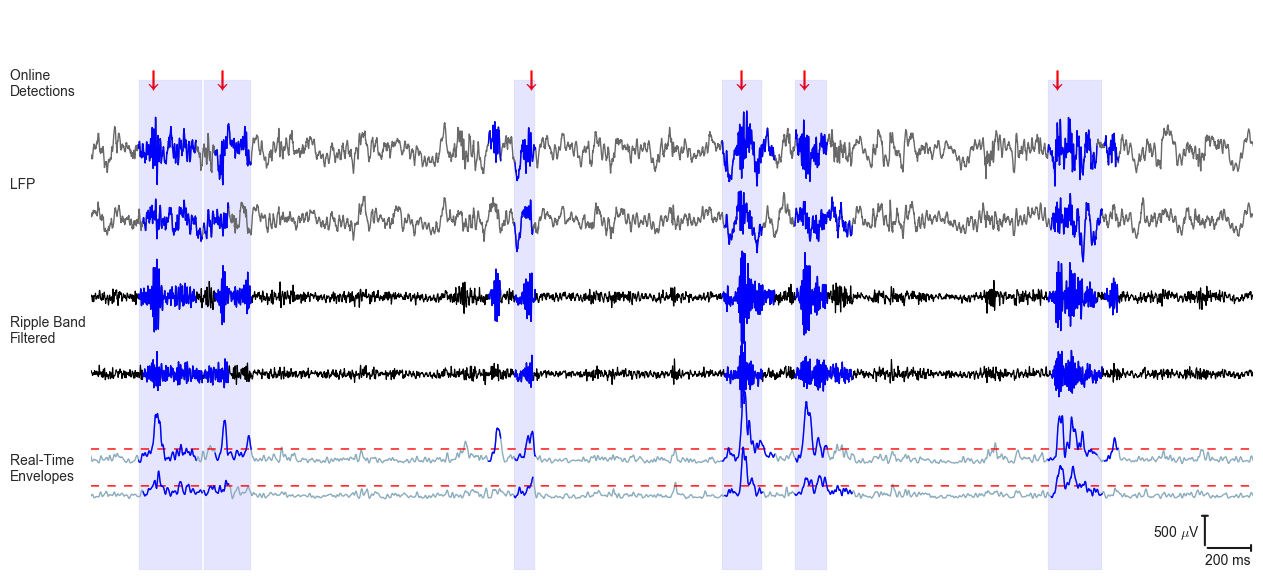

In [7]:
#plot settings
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (15, 7),'lines.linewidth': 1, 'font.size': 10, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

saveFigs = True

#plot handles and xlim
ax = plt.gca()
xrange = [60.25,65]

#Online Detections
arrow = u'$\u2193$'
ax.scatter(timeStampsSeconds[onlineDetectBounds[:,0]]-1244, np.ones(onlineDetectBounds[:,0].shape)*6000,color="red",s=200,marker=arrow,label="Online Detection") #detection timestamp

#LFP
npl.plot(offlineLFP[:,0].clip(-800,800)[nel.EpochArray(xrange)]+5000, c='dimgray') #t2
npl.plot(offlineLFP[:,1].clip(-800,800)[nel.EpochArray(xrange)]+4000, c='dimgray',) #t3

#LFP Ripples
npl.plot(offlineLFP[:,1].clip(-800,800)[nel.EpochArray(xrange)][rippleEpochsT3]+4000, c='blue')
npl.plot(offlineLFP[:,0].clip(-800,800)[nel.EpochArray(xrange)][rippleEpochsT2]+5000, c='blue')

#Ripple Band Filtered
npl.plot((realtimesignals[:,2][nel.EpochArray(xrange)]+7250)/2.5, c='black', lw=0.85,) #t2
npl.plot((realtimesignals[:,3][nel.EpochArray(xrange)]+4500)/2.5, c='black', lw=0.85) #t3

#Ripple Band Filtered Ripples
npl.plot((realtimesignals[:,3][nel.EpochArray(xrange)][rippleEpochsT3]+4500)/2.5, c='blue')
npl.plot((realtimesignals[:,2][nel.EpochArray(xrange)][rippleEpochsT2]+7250)/2.5, c='blue')

#Envelope 
npl.plot((realtimesignals[:,0][nel.EpochArray(xrange)]+500), c='#8dadbd') #t2
plt.plot(timeStampsSeconds-1244, (np.ones(dataT2.shape)*228.9)+500, c='red', linestyle='--') #t2
ax = npl.plot((realtimesignals[:,1][nel.EpochArray(xrange)]), c='#8dadbd') #t3
plt.plot(timeStampsSeconds-1244, (np.ones(dataT3.shape)*201.7), c='red', linestyle='--') #t3

#Envelope Ripples
npl.plot((realtimesignals[:,1][nel.EpochArray(xrange)][rippleEpochsT3]), c='blue')
npl.plot((realtimesignals[:,0][nel.EpochArray(xrange)][rippleEpochsT2]+500), c='blue')

#Canonical Ripple Epochs
npl.epochplot(rippleEpochs,ax=ax,color='blue',alpha=0.1,hatch='',height=7000)

#remove box and scale bars
# npl.scalebar.add_scalebar(ax=ax, sizey=500, labely='500 $\mu$V',pad=0, loc=4,bbox_to_anchor=(1263,425))
npl.scalebar.add_scalebar(ax=ax, sizex=0.2, labelx='200 ms', sizey=500, labely='500 $\mu$V',\
                          pad=0, loc=4,)
npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)
plt.xlim(xrange)

#labels
ax.text(59.92,realtimesignals[:,1][nel.EpochArray(xrange)].min()+5750,'Online \nDetections')
ax.text(59.92,realtimesignals[:,1][nel.EpochArray(xrange)].min()+4425,'LFP')
ax.text(59.92,realtimesignals[:,1][nel.EpochArray(xrange)].min()+2225,'Ripple Band \nFiltered')
ax.text(59.92,realtimesignals[:,1][nel.EpochArray(xrange)].min()+250,'Real-Time \nEnvelopes')

if saveFigs:
    plt.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/signals.svg',bbox_inches='tight')

plt.show()

# Generate part (b)

## Load data

In [2]:
npzfile = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure7/Figure7B.npz")
#simulated = Calc
detectionLatencyCalc = npzfile["detectionLatencyCalc"]
fpRateCalc = npzfile['fpRateCalc']
fpPercentCalc = npzfile['fpPercentCalc']
tpRateCalc = npzfile['tpRateCalc']
#measured = Calc2
detectionLatencyCalc2 = npzfile['detectionLatencyCalc2']
fpRateCalc2 = npzfile['fpRateCalc2']
fpPercentCalc2 = npzfile['fpPercentCalc2']
tpRateCalc2 = npzfile['tpRateCalc2']
 #detection lat scatter
scatter = npzfile['scatter']

In [38]:
print("Average Detection Latency: Simulated {} | Measured {}".format(np.mean(detectionLatencyCalc),np.mean(detectionLatencyCalc2)))
print("Average True Positive Rate: Simulated {} | Measured {}".format(np.mean(tpRateCalc),np.mean(tpRateCalc2)))
print("Average False Stimulations Per Second: Simulated {} | Measured {}".format(np.mean(fpRateCalc),np.mean(fpRateCalc2)))
print("Average False Detection Percentage: Simulated {} | Measured {}".format(np.mean(fpPercentCalc),np.mean(fpPercentCalc2)))
print("Average Online vs Simulated Latency: {}ms".format(np.mean(scatter[:,0]-scatter[:,1])))
print("Median Online vs Simulated Latency: {}ms".format(np.median(scatter[:,0]-scatter[:,1])))

Average Detection Latency: Simulated 53.321781300000005 | Measured 54.6212516
Average True Positive Rate: Simulated 0.9948200709999999 | Measured 0.9948200709999999
Average False Stimulations Per Second: Simulated 0.27463415399999996 | Measured 0.27450083799999997
Average False Detection Percentage: Simulated 0.574500019 | Measured 0.574500019
Average Online vs Simulated Latency: 1.9241238482384821ms
Median Online vs Simulated Latency: 2.0ms


## Plot!

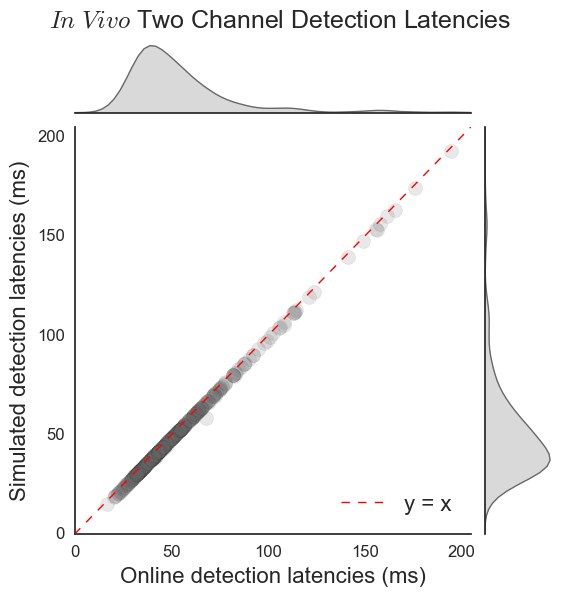

In [37]:
saveFigs = True
mpl.rcdefaults()
sns.set(rc={'figure.figsize': (3, 3),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')


x = np.arange(500)
y = x

df = pd.DataFrame(scatter, columns=["Online detection latencies (ms)","Simulated detection latencies (ms)"])
g = sns.JointGrid(x="Online detection latencies (ms)", y="Simulated detection latencies (ms)", data=df,xlim=[0,205],ylim=[0,205]) #setup grid
g.fig.suptitle("$In$ $Vivo$ Two Channel Detection Latencies",y=1.01)
g = g.plot_joint(plt.scatter, c='dimgray',alpha=0.15,s=100,zorder=1) #scatter plot
g = g.plot_marginals(sns.kdeplot, color='dimgray',shade=True) #distributions
g.ax_joint.plot(x,y, 'r--',label='y = x',zorder=3,color='red') #1 to 1 line
# g.ax_joint.plot(np.asarray([100]),np.asarray([100]),'ko',zorder=4) #100 ms dot
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.loadtxt('paperData/singleChanAnalysis/scatter.out')[:,0],np.loadtxt('paperData/singleChanAnalysis/scatter.out')[:,1])
# g.ax_joint.plot(x,(slope*x)+intercept,'k',label='Regression',zorder=2)
g.ax_joint.legend(loc='lower right')
plt.show()
if (saveFigs):
    g.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/scatter-two.svg')

In [14]:
scatter[:,1].shape

(369,)

## Calculate HDI ~80%

In [10]:
min(detectionLatencyCalc2.squeeze())

51.9893

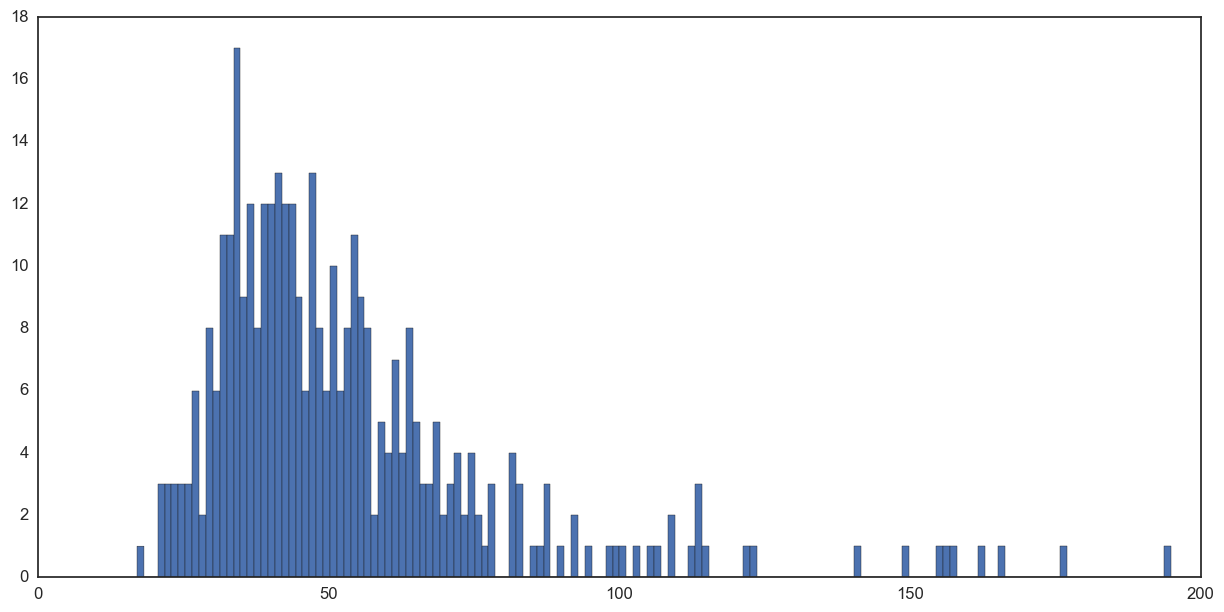

In [17]:
#plot settings
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (15, 7),'lines.linewidth': 1, 'font.size': 10, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')
plt.hist(scatter[:,0],bins=300)
plt.xlim(0,200)
plt.show()

In [34]:
(np.asarray(np.where(scatter[:,0]>20)).size - \
 np.asarray(np.where(scatter[:,0]>66)).size)\
/len(scatter[:,0])

0.8048780487804879

80% HDI of real-time ripple detections are between 20 and 66 ms 

# Final Figure!

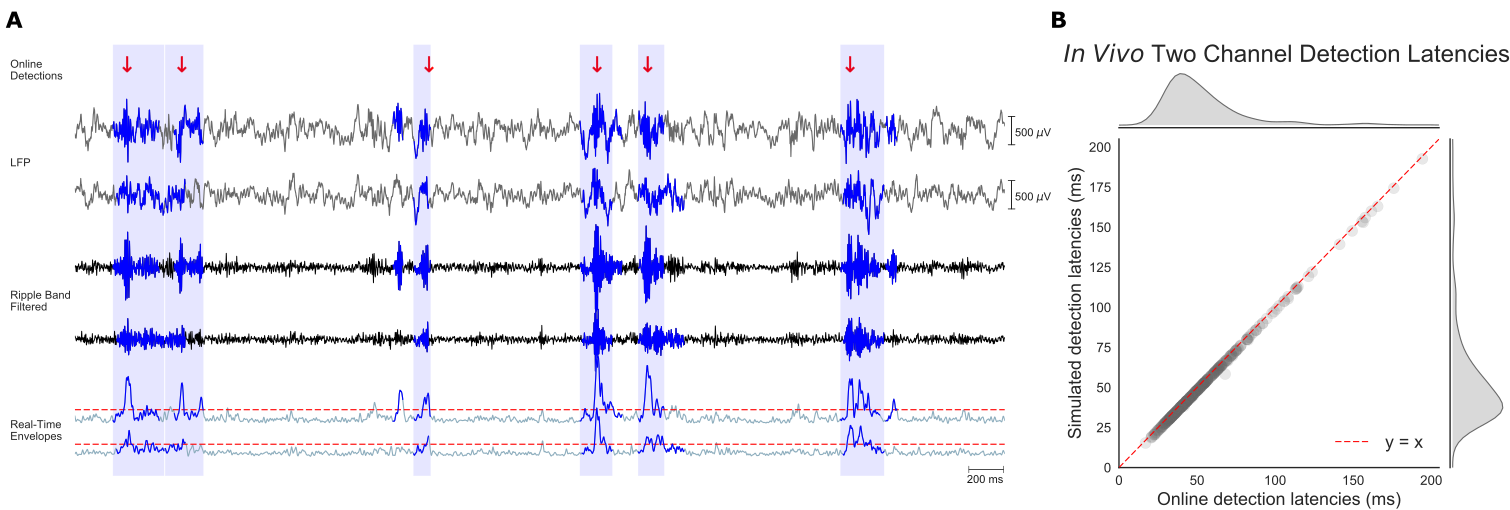

In [43]:
#create new SVG figure
fig = sg.SVGFigure("15.1in", "5.1in")

#load matplotlib-generated figures
fig1 = sg.fromfile("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/signals.svg")
fig2 = sg.fromfile('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/scatter-two.svg')

#get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot1.moveto(10, 25+8, scale=1)
plot2.moveto(950, 25+8, scale=1)

#add text labels
txt1 = sg.TextElement(5,25, "A", size=20, weight="bold")
txt2 = sg.TextElement(945,25, "B", size=20, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2])
fig.append([txt1, txt2])

fig.save("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.svg")
os.system("inkscape --export-pdf=/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.pdf /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.svg")
os.system("convert -density 150 /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/figFinal.pdf -quality 100 /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.png")
display(Image(filename='/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.png'))

# Edit the scale bars for part A in Inkscape!
I'm sure I could do this in within Python but nahhh

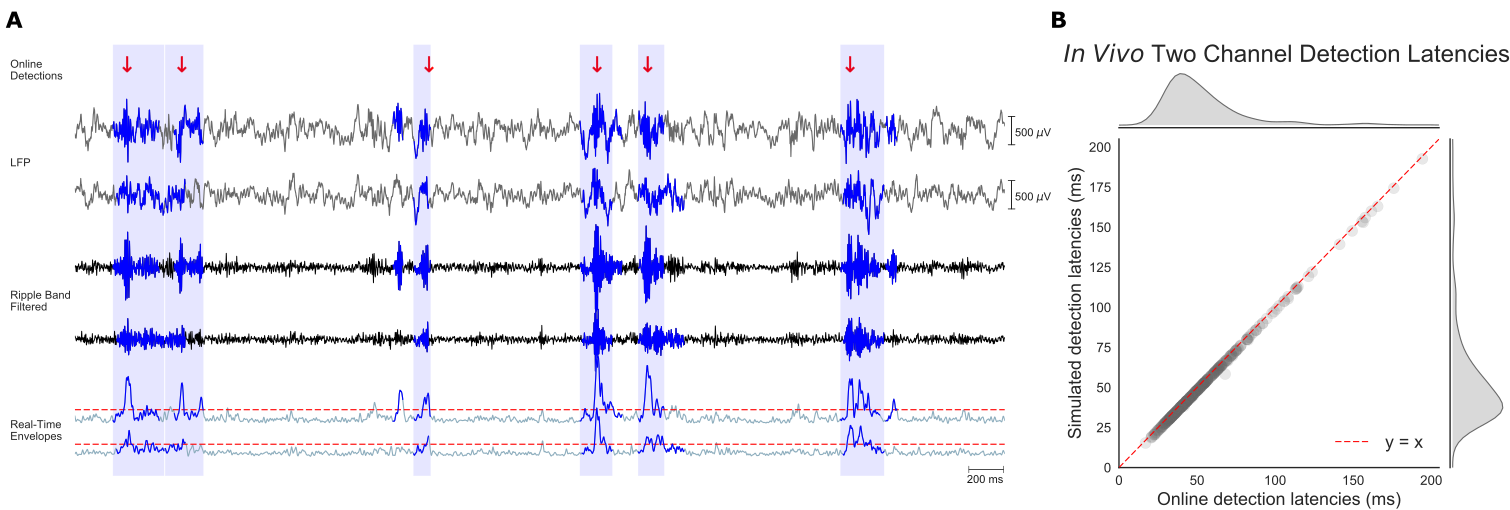

In [44]:
display(Image(filename='/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/figure7_twochanneldetections/fig7Final.png'))